In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import re
sns.set_theme(style="darkgrid")


In [2]:
original_df = pd.read_csv('./input/train.csv')
train_df = pd.read_csv('train_df.csv')
train_df['transaction_year_month'] = original_df['transaction_year_month']
train_df

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price
0,1,138,23,84.8200,41,200801,6,37500,0,10.532123,4.452252,37500.0
1,1,65,23,99.1700,12,200801,10,20000,0,9.903538,4.606869,29250.0
2,1,65,23,84.7400,46,200801,10,38500,0,10.558439,4.451319,29250.0
3,1,13,23,146.3900,42,200801,19,118000,0,11.678448,4.993082,119000.0
4,1,13,23,194.4300,43,200801,7,120000,0,11.695255,5.275202,119000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,201711,7,22000,0,9.998843,4.107993,27615.0
1216549,0,305,23,84.9923,51,201711,11,30750,0,10.333678,4.454258,27615.0
1216550,0,305,23,84.9923,51,201711,13,29500,0,10.292179,4.454258,27615.0
1216551,0,305,10,101.7400,47,201711,11,26700,1,10.192456,4.632202,26850.0


In [3]:
train_df.describe()

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.101543e-01,2.408951e+02,2.036546e+01,7.816549e+01,3.729657e+01,2.012984e+05,1.334329e+01,3.822769e+04,1.234225e-01,1.030509e+01,4.306133e+00,3.822769e+04
std,4.877153e-01,1.267480e+02,6.552019e+00,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04,3.289217e-01,7.054740e-01,3.685930e-01,2.737147e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,2.008010e+05,0.000000e+00,1.000000e+02,0.000000e+00,4.615121e+00,2.328253e+00,7.150000e+02
25%,0.000000e+00,1.300000e+02,1.700000e+01,5.976000e+01,3.200000e+01,2.010100e+05,8.000000e+00,1.900000e+04,0.000000e+00,9.852247e+00,4.106932e+00,2.068485e+04
50%,1.000000e+00,2.580000e+02,2.300000e+01,8.241000e+01,3.800000e+01,2.013120e+05,1.200000e+01,3.090000e+04,0.000000e+00,1.033854e+01,4.423768e+00,3.095238e+04
75%,1.000000e+00,3.380000e+02,2.300000e+01,8.497000e+01,4.400000e+01,2.015110e+05,1.700000e+01,4.700000e+04,0.000000e+00,1.075792e+01,4.453998e+00,4.683455e+04
max,1.000000e+00,4.760000e+02,3.400000e+01,4.243200e+02,5.600000e+01,2.017110e+05,8.400000e+01,8.200000e+05,1.000000e+00,1.361706e+01,6.052842e+00,5.700000e+05


In [4]:
with open('apt_dict.json', 'r') as f:
    apt_dict = json.load(f)
apt_dict = {int(k):v for k,v in apt_dict.items()}
with open('dong_dict.json', 'r') as f:
    dong_dict = json.load(f)
dong_dict = {int(k):v for k,v in dong_dict.items()}

In [5]:
lgb_df = pd.read_csv('train_df.csv').drop(['exclusive_use_area', 'transaction_real_price', 'average_price'], axis=1)
print(lgb_df.shape)
lgb_df.head()

(1216553, 9)


,city,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area
0,1,138,23,41,0,6,0,10.532123,4.452252
1,1,65,23,12,0,10,0,9.903538,4.606869
2,1,65,23,46,0,10,0,10.558439,4.451319
3,1,13,23,42,0,19,0,11.678448,4.993082
4,1,13,23,43,0,7,0,11.695255,5.275202


In [6]:
params = {'max_depth': 12, 'learning_rate': 0.00997868692396887,
 'n_estimators': 2327, 'min_child_samples': 8, 'subsample': 0.48772098248194684}

cut = int(len(lgb_df) * 0.75)
tr = lgb_df.iloc[:cut]
te = lgb_df.iloc[cut:]
print(tr.shape, te.shape)

model = lgb.LGBMRegressor(**params)
model.fit(tr.drop('log_price', axis=1), tr['log_price'])
pred = model.predict(te.drop('log_price', axis=1))
te['pred'] = np.expm1(pred)
te

(912414, 9) (304139, 9)


/tmp/ipykernel_4713/2492163944.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te['pred'] = np.expm1(pred)


,city,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,pred
912414,0,329,31,35,101,10,0,10.275086,4.106438,22438.749015
912415,0,329,27,37,101,16,1,9.952325,4.110710,21825.453173
912416,0,329,31,35,101,19,0,10.485731,4.454231,31847.834500
912417,0,329,23,35,101,7,0,10.609082,4.912581,37331.820886
912418,0,329,14,35,101,5,0,9.980495,4.109890,19939.324190
...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,51,118,7,0,9.998843,4.107993,24792.438286
1216549,0,305,23,51,118,11,0,10.333678,4.454258,35168.261472
1216550,0,305,23,51,118,13,0,10.292179,4.454258,35730.324153
1216551,0,305,10,47,118,11,1,10.192456,4.632202,47043.416112


In [7]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

RMSE(te['log_price'], np.log1p(te['pred']))

0.21335324028008182

In [8]:
concat_df = pd.concat([tr, te], axis=0)
concat_df = pd.concat([train_df, concat_df['pred']], axis=1)

In [9]:
jamsil = concat_df.loc[concat_df['apt']==0, 'dong'].unique()
for d in jamsil:
    print(d, dong_dict[d])

29 신천동
85 석촌동
17 잠실동


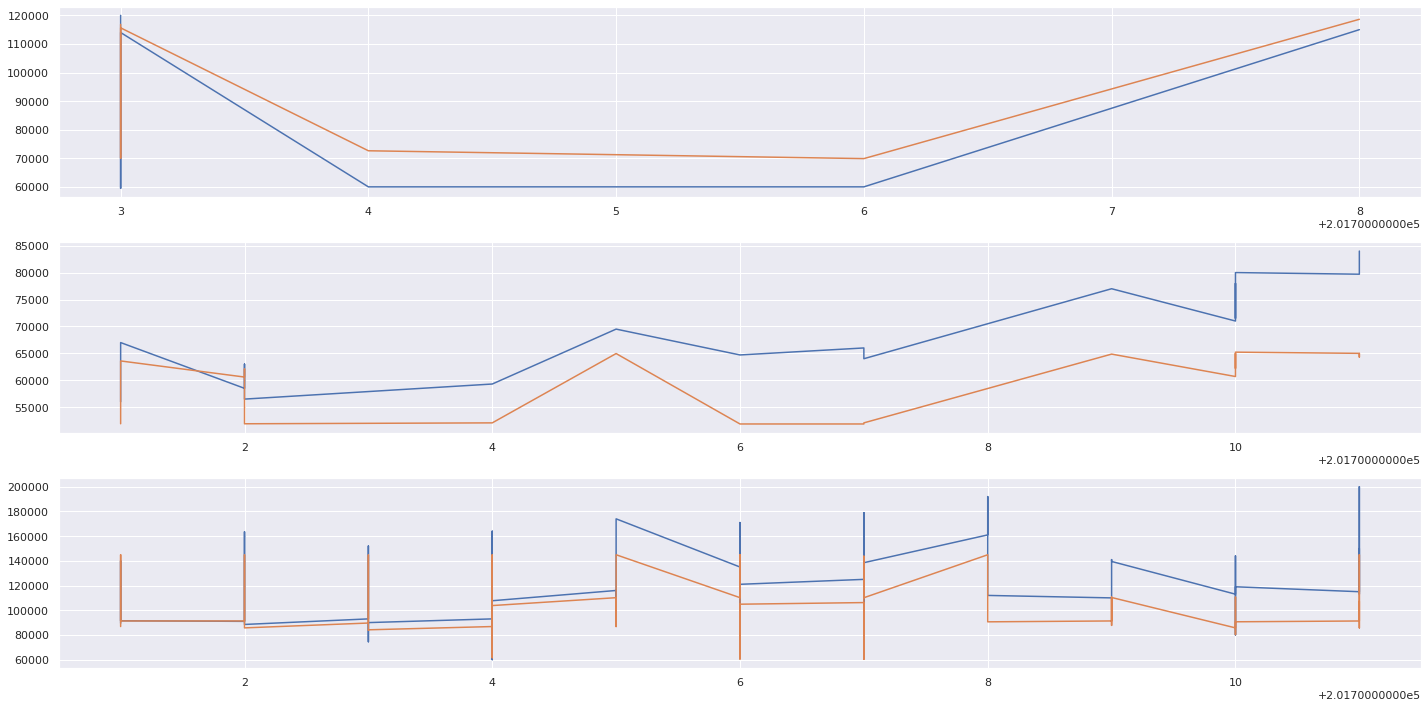

In [10]:
apt = 0
f, ax = plt.subplots(3, 1, figsize=(20, 10))
dong_list = train_df.loc[train_df['apt']==apt, 'dong'].unique()
for i, dong in enumerate(dong_list):
    ax[i].plot(
        train_df[len(tr):].loc[(train_df['apt']==apt) & (train_df['dong']==dong), 'transaction_year_month'],
        train_df[len(tr):].loc[(train_df['apt']==apt) & (train_df['dong']==dong), 'transaction_real_price'],
        concat_df[len(tr):].loc[(concat_df['apt']==apt) & (concat_df['dong']==dong), 'transaction_year_month'],
        concat_df[len(tr):].loc[(concat_df['apt']==apt) & (concat_df['dong']==dong), 'pred'],
        )
    # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [11]:
concat_df

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price,pred
0,1,138,23,84.8200,41,200801,6,37500,0,10.532123,4.452252,37500.0,NaN
1,1,65,23,99.1700,12,200801,10,20000,0,9.903538,4.606869,29250.0,NaN
2,1,65,23,84.7400,46,200801,10,38500,0,10.558439,4.451319,29250.0,NaN
3,1,13,23,146.3900,42,200801,19,118000,0,11.678448,4.993082,119000.0,NaN
4,1,13,23,194.4300,43,200801,7,120000,0,11.695255,5.275202,119000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216548,0,305,23,59.8245,51,201711,7,22000,0,9.998843,4.107993,27615.0,24792.438286
1216549,0,305,23,84.9923,51,201711,11,30750,0,10.333678,4.454258,27615.0,35168.261472
1216550,0,305,23,84.9923,51,201711,13,29500,0,10.292179,4.454258,27615.0,35730.324153
1216551,0,305,10,101.7400,47,201711,11,26700,1,10.192456,4.632202,26850.0,47043.416112


29
85
17


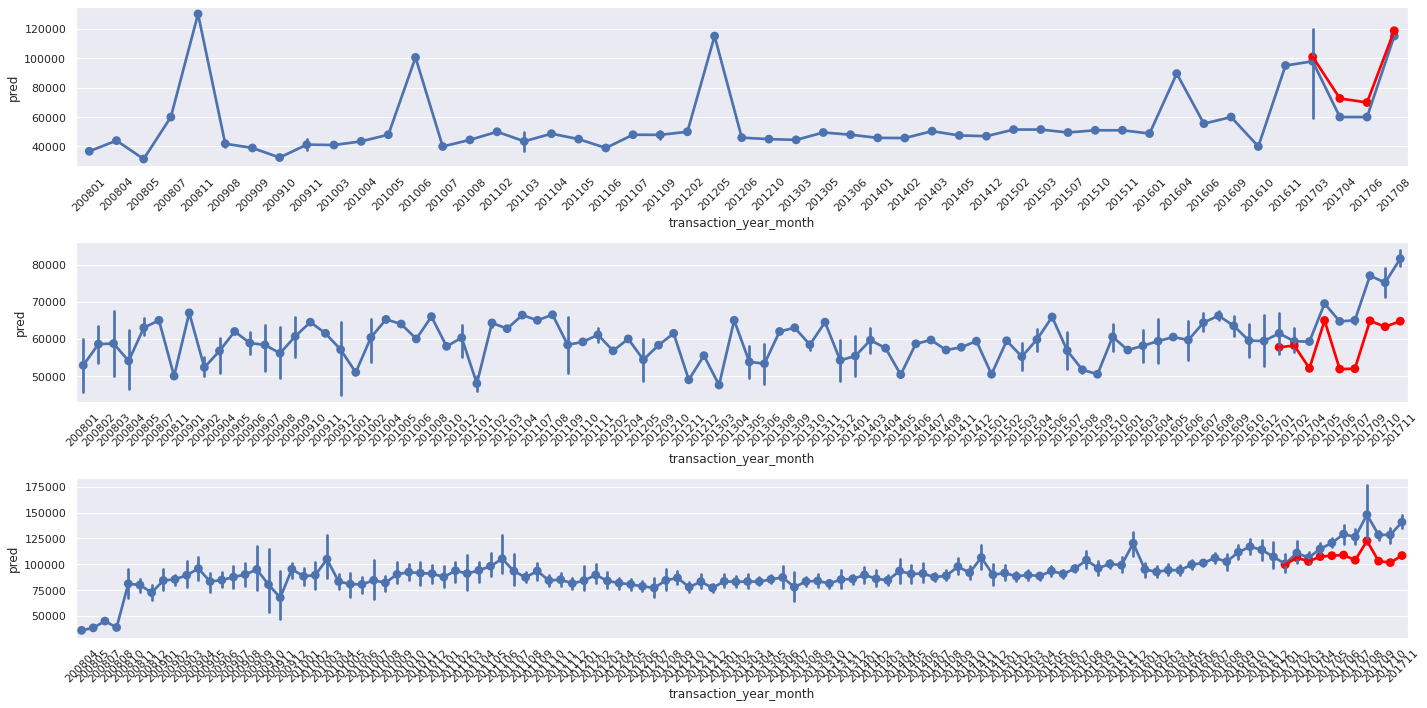

In [176]:
dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
f, ax = plt.subplots(3, 1, figsize=(20, 10))
for i, dong in enumerate(dong_list):
    print(dong)
    sns.pointplot(x='transaction_year_month', y='transaction_real_price', data=train_df.loc[(train_df['apt']==0) & (train_df['dong']==dong)], ax=ax[i])
    sns.pointplot(x='transaction_year_month', y='pred', data=concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==dong)], ax=ax[i], color='red', ci=None)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    # ax[i].set_title(dong_dict[dong])
plt.tight_layout()
plt.show()

In [ ]:
concat_df['difference'] = concat_df['pred'] - concat_df['transaction_real_price']
concat_df.loc[concat_df['difference'].idxmax()]

city                           1.000000
dong                           5.000000
apt                           26.000000
exclusive_use_area           106.580000
year_of_completion            13.000000
transaction_year_month    201706.000000
floor                          8.000000
transaction_real_price     90000.000000
top10                          0.000000
log_price                     11.407576
log_area                       4.678235
average_price             142635.714286
pred                      180548.451985
difference                 90548.451985
Name: 1163427, dtype: float64

In [ ]:
concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==17) & (concat_df['pred'].notnull())]

,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,top10,log_price,log_area,average_price,pred,difference
1171580,1,17,0,59.96,47,201701,7,89500,0,11.402005,4.110218,100454.545455,86806.656874,-2693.343126
1171586,1,17,0,59.96,47,201701,9,90000,0,11.407576,4.110218,100454.545455,87318.504065,-2681.495935
1171587,1,17,0,84.80,47,201701,15,114000,0,11.643962,4.452019,100454.545455,107809.880096,-6190.119904
1171590,1,17,0,119.93,47,201701,30,140000,0,11.849405,4.795212,100454.545455,144891.531297,4891.531297
1171592,1,17,0,59.96,47,201701,19,90000,0,11.407576,4.110218,100454.545455,90657.057710,657.057710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178124,1,17,0,84.97,47,201711,26,138000,0,11.835016,4.453998,140870.588235,110594.189073,-27405.810927
1178126,1,17,0,84.80,47,201711,14,149000,0,11.911708,4.452019,140870.588235,107206.197688,-41793.802312
1178127,1,17,0,119.93,47,201711,14,180000,0,12.100718,4.795212,140870.588235,139802.117879,-40197.882121
1178128,1,17,0,84.88,47,201711,5,130000,0,11.775297,4.452951,140870.588235,101881.353160,-28118.646840


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

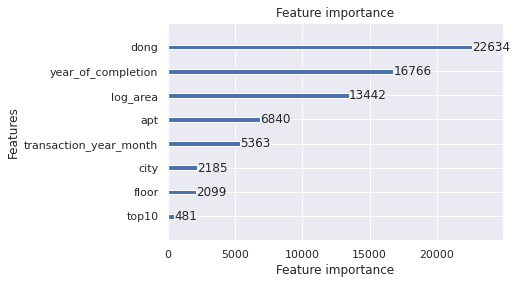

In [ ]:
lgb.plot_importance(model)

In [ ]:
dt = DecisionTreeRegressor(max_depth=3, random_state=42, )
dt.fit(tr.drop('log_price', axis=1), tr['log_price'])

DecisionTreeRegressor(max_depth=3, random_state=42)

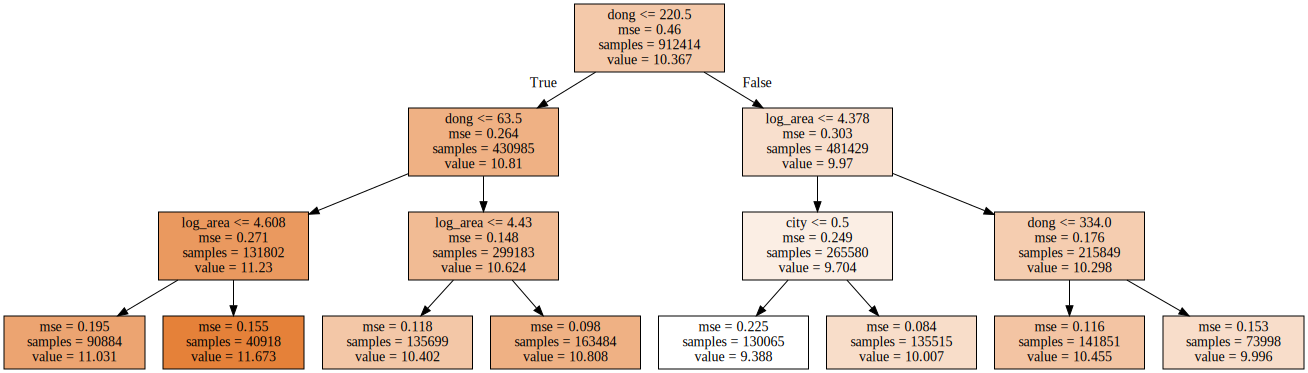

In [ ]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=tr.drop('log_price', axis=1).columns,
    filled=True
    )
graph = graphviz.Source(dot_data, format='png')
filename = graph.render(filename='tree.png')
graph

In [ ]:
concat_df.reset_index(inplace=True)

In [152]:
concat_df['difference'] = abs(concat_df['pred'] - concat_df['transaction_real_price'])
gdf = concat_df.groupby(['apt', 'dong', 'floor', 'exclusive_use_area'])[['difference']].median().reset_index()
gdf

,apt,dong,floor,exclusive_use_area,difference
0,0,17,5,59.9600,5837.128642
1,0,17,5,84.8000,750.000000
2,0,17,5,84.8800,5381.353160
3,0,17,5,84.9700,NaN
4,0,17,5,119.9300,NaN
...,...,...,...,...,...
278292,34,444,27,84.9961,7019.651134
278293,34,444,28,59.9942,5377.315882
278294,34,444,28,84.9961,7504.048661
278295,34,444,29,59.9942,5566.501754


In [153]:
tdf = concat_df.groupby(['apt', 'dong', 'floor', 'exclusive_use_area'])[['transaction_real_price']].count().reset_index()
tdf

,apt,dong,floor,exclusive_use_area,transaction_real_price
0,0,17,5,59.9600,7
1,0,17,5,84.8000,17
2,0,17,5,84.8800,11
3,0,17,5,84.9700,4
4,0,17,5,119.9300,3
...,...,...,...,...,...
278292,34,444,27,84.9961,18
278293,34,444,28,59.9942,45
278294,34,444,28,84.9961,18
278295,34,444,29,59.9942,52


In [154]:
cdf = concat_df.groupby(['apt', 'dong', 'floor', 'exclusive_use_area'])[['pred']].count().reset_index()
cdf

,apt,dong,floor,exclusive_use_area,pred
0,0,17,5,59.9600,1
1,0,17,5,84.8000,2
2,0,17,5,84.8800,3
3,0,17,5,84.9700,0
4,0,17,5,119.9300,0
...,...,...,...,...,...
278292,34,444,27,84.9961,18
278293,34,444,28,59.9942,45
278294,34,444,28,84.9961,18
278295,34,444,29,59.9942,52


In [155]:
gdf = pd.merge(gdf, cdf, on=['apt', 'dong', 'floor', 'exclusive_use_area'], how='outer')
gdf = pd.merge(gdf, tdf, on=['apt', 'dong', 'floor', 'exclusive_use_area'], how='outer')
gdf.rename(columns={'pred': 'pred_count', 'transaction_real_price': 'real_count'}, inplace=True)
gdf1 = gdf.sort_values(by='difference').reset_index(drop=True)
gdf1

,apt,dong,floor,exclusive_use_area,difference,pred_count,real_count
0,27,343,5,84.9972,0.063259,1,1
1,23,96,16,114.9200,0.164087,1,5
2,23,410,7,68.8500,0.206770,1,4
3,15,83,13,84.6400,0.218601,1,7
4,26,422,22,141.1300,0.343101,1,1
...,...,...,...,...,...,...,...
278292,34,417,40,84.8700,NaN,0,2
278293,34,417,40,84.9630,NaN,0,3
278294,34,417,40,84.9840,NaN,0,1
278295,34,417,41,84.6000,NaN,0,2


In [159]:
gdf = gdf1.loc[(10 <= gdf1['pred_count']) & (30 > gdf1['pred_count']) & (gdf1['real_count']>30)].sort_values(by='difference').reset_index(drop=True)
# gdf = gdf1.dropna()
gdf

,apt,dong,floor,exclusive_use_area,difference,pred_count,real_count
0,23,404,8,39.67,311.640345,15,133
1,23,404,7,39.67,450.000000,10,92
2,25,294,18,44.52,451.038099,13,36
3,26,299,14,84.94,510.002980,13,78
4,25,244,18,44.52,689.609220,12,97
...,...,...,...,...,...,...,...
267,25,17,13,76.50,22096.092018,12,73
268,25,41,8,50.64,27648.851041,10,65
269,23,5,7,72.51,30461.339908,11,104
270,25,41,5,58.08,36603.255472,11,63


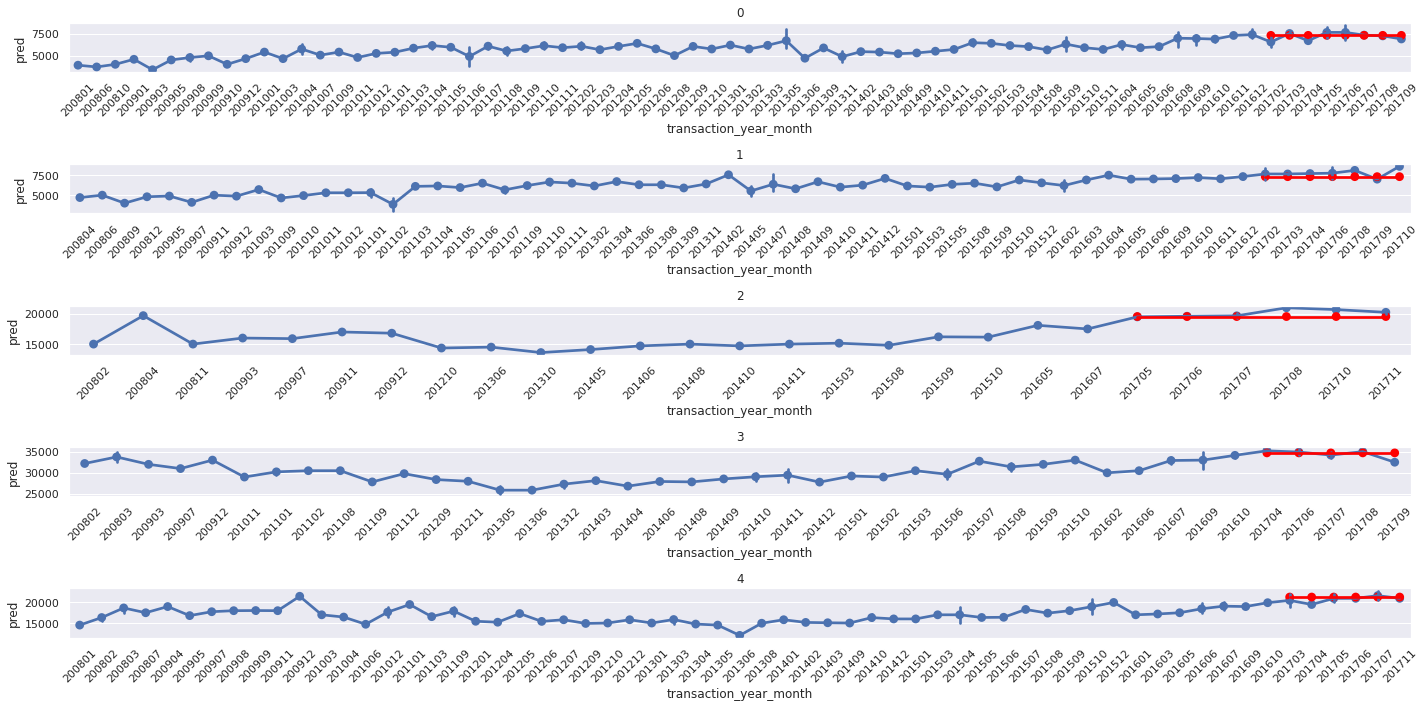

In [169]:
n = 5
a = 0
f, ax = plt.subplots(n-a, 1, figsize=(20, 10))
for i in range(a,n):
    g_apt = gdf['apt'][i]
    g_dong = gdf['dong'][i]
    g_floor = gdf['floor'][i]
    g_area = gdf['exclusive_use_area'][i]
    # print(g_apt, g_dong, g_floor, g_area)
    df = concat_df.loc[
        (concat_df['apt']==g_apt) & (concat_df['dong']==g_dong) & (concat_df['floor']==g_floor) & (concat_df['exclusive_use_area']==g_area)
    ]
    # dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
    sns.pointplot(x='transaction_year_month', y='transaction_real_price', data=df, ax=ax[i-a])
    sns.pointplot(x='transaction_year_month', y='pred', data=df, ax=ax[i-a], color='red', ci=None)
    ax[i-a].set_xticklabels(ax[i-a].get_xticklabels(), rotation=45)
    ax[i-a].set_title(i)
plt.tight_layout()
plt.show()

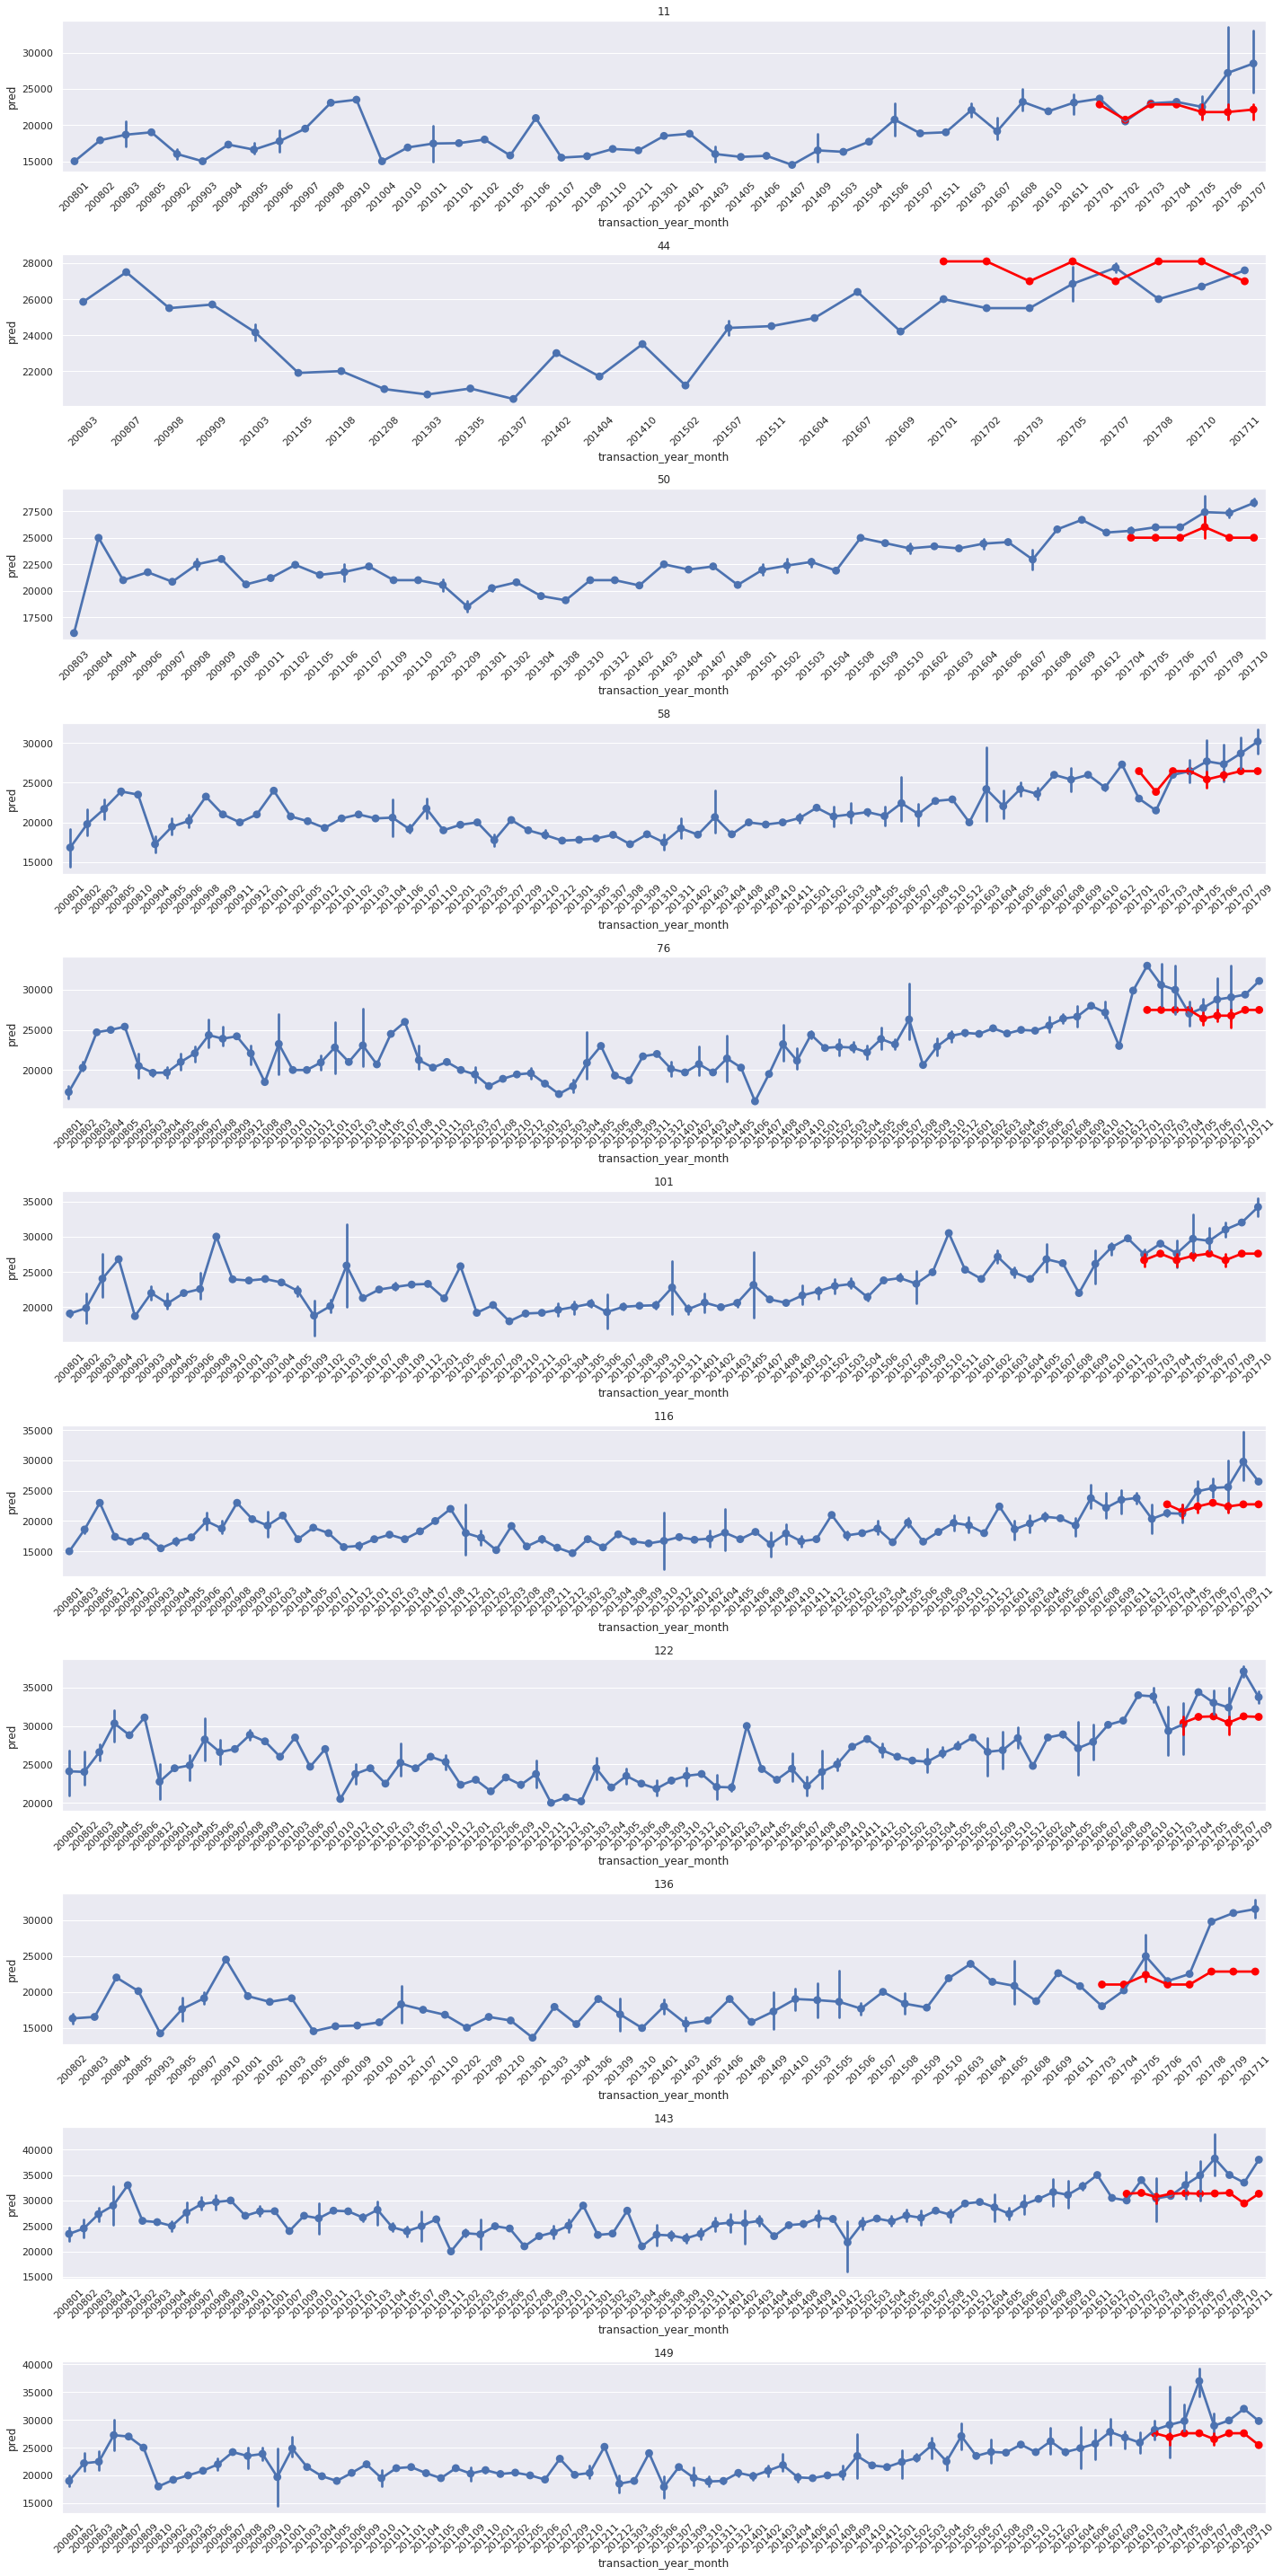

In [174]:
f, ax = plt.subplots(11, 1, figsize=(20, 40))
for i, v in enumerate([11, 44, 50, 58, 76, 101, 116, 122, 136, 143, 149]):
    g_apt = gdf['apt'][v]
    g_dong = gdf['dong'][v]
    g_floor = gdf['floor'][v]
    g_area = gdf['exclusive_use_area'][v]
    # print(g_apt, g_dong, g_floor, g_area)
    df = concat_df.loc[
        (concat_df['apt']==g_apt) & (concat_df['dong']==g_dong) & (concat_df['floor']==g_floor) & (concat_df['exclusive_use_area']==g_area)
    ]
    # dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
    sns.pointplot(x='transaction_year_month', y='transaction_real_price', data=df, ax=ax[i])
    sns.pointplot(x='transaction_year_month', y='pred', data=df, ax=ax[i], color='red')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    ax[i].set_title(v)
plt.tight_layout()
plt.show()

In [ ]:
# 29
dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
f, ax = plt.subplots(3, 1, figsize=(20, 10))
for i, dong in enumerate(dong_list):
    print(dong)
    sns.pointplot(x='transaction_year_month', y='transaction_real_price', data=train_df.loc[(train_df['apt']==0) & (train_df['dong']==dong)], ax=ax[i])
    sns.pointplot(x='transaction_year_month', y='pred', data=concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==dong)], ax=ax[i], color='red', ci=None)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
    # ax[i].set_title(dong_dict[dong])
plt.tight_layout()
plt.show()

In [184]:
gdf.iloc[[11, 44, 50, 58, 76, 101, 116, 122, 136, 143, 149]]

,apt,dong,floor,exclusive_use_area,difference,pred_count,real_count
11,25,313,9,45.90,808.033436,11,77
44,16,280,8,70.62,1445.618342,10,34
50,23,287,10,49.60,1533.740738,12,73
58,25,313,5,49.94,1686.363355,26,161
76,25,313,7,49.94,1988.152402,29,195
101,25,313,13,49.94,2586.852864,21,167
116,25,313,8,41.30,2905.114540,20,159
122,25,313,7,58.01,3000.000000,22,167
136,25,313,12,45.90,3345.562374,12,77
143,25,313,12,58.01,3469.030560,20,193


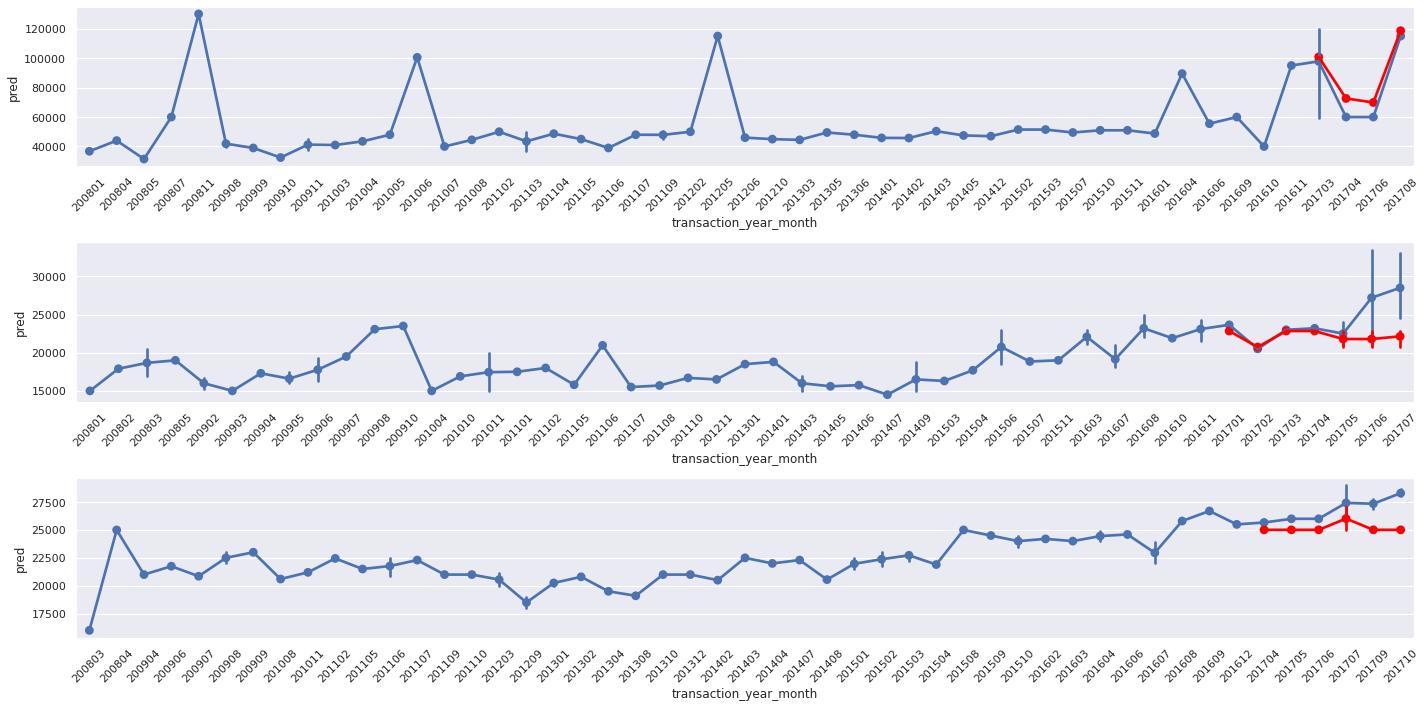

In [185]:
f, ax = plt.subplots(3, 1, figsize=(20, 10))
for i, v in enumerate([0, 11, 50]):
    g_apt = gdf['apt'][v]
    g_dong = gdf['dong'][v]
    g_floor = gdf['floor'][v]
    g_area = gdf['exclusive_use_area'][v]
    # print(g_apt, g_dong, g_floor, g_area)
    df = concat_df.loc[
        (concat_df['apt']==g_apt) & (concat_df['dong']==g_dong) & (concat_df['floor']==g_floor) & (concat_df['exclusive_use_area']==g_area)
    ]
    # dong_list = train_df.loc[train_df['apt']==0, 'dong'].unique()
    if i == 0:
        sns.pointplot(x='transaction_year_month', y='transaction_real_price', data=train_df.loc[(train_df['apt']==0) & (train_df['dong']==29)], ax=ax[i])
        sns.pointplot(x='transaction_year_month', y='pred', data=concat_df.loc[(concat_df['apt']==0) & (concat_df['dong']==29)], ax=ax[i], color='red', ci=None)
    else:
        sns.pointplot(x='transaction_year_month', y='transaction_real_price', data=df, ax=ax[i])
        sns.pointplot(x='transaction_year_month', y='pred', data=df, ax=ax[i], color='red')
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


In [186]:
# 신천동 '잠실'아파트
# 상계동 '주공'아파트
# 공릉동 'others'아파트
print(dong_dict[gdf['dong'][11]], apt_dict[gdf['apt'][11]])
print(dong_dict[gdf['dong'][50]], apt_dict[gdf['apt'][50]])

상계동 주공
공릉동 others
